In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, GaussianNoise, BatchNormalization, UpSampling2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [3]:
'mnist' in tfds.list_builders()

True

# Loading data and preprocessing

In [4]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


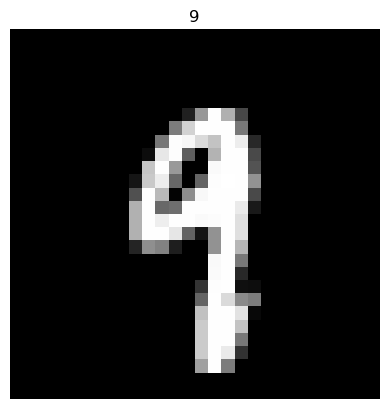

In [5]:
import numpy as np
# Datapreprocessing
x_train = x_train.reshape((60_000, 28, 28, 1))
x_test = x_test.reshape((10_000, 28, 28, 1))

# Normalizing the values
x_train = x_train.astype(np.float64)/255.0
x_test = x_test.astype(np.float64)/255.0

idx = np.random.randint(0,60_000)
plt.imshow(x_train[idx, :, :, :], cmap='gray')
plt.title(y_train[idx])
plt.axis('off')
plt.show()


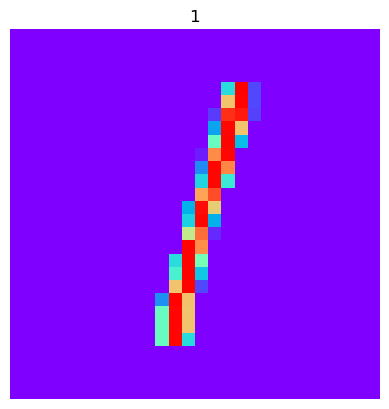

In [6]:
idx = np.random.randint(0,60_000)
plt.imshow(x_train[idx, :, :, :], cmap='rainbow')
plt.title(y_train[idx])
plt.axis('off')
plt.show()

# Change dataset into something easy to process using tensorflow

In [7]:
batch_size = 32

# Prepare the training dataset
# Need only images, not labels
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [8]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

# Reload the dataset 
ds = tfds.load('mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Make a Generator and Discriminator model

In [9]:
def make_generator():
#     input_noise = Input(128, name='Noise-input')
#     x = Dense(128*2, activation='relu')(input_noise)
#     x = BatchNormalization()(x)
#     x = Dense(128*8, activation='relu')(x)
#     x = Dense(784, activation='sigmoid')(x)
#     output_img = Reshape((28,28,1))(x)
#     model = Model(inputs = [input_noise], outputs = [output_img], name="Generator-model")
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [10]:
generator = make_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [11]:
def make_discriminator():
#     input_image = Input((28, 28, 1), name='Image-input')
# #     x = GaussianNoise(0.5)(input_image)
#     x = Conv2D(64, (3,3), activation='relu')(input_image)
#     x = MaxPooling2D((2,2))(x)
#     x = Conv2D(32, (3,3), activation="relu")(x)
#     x = MaxPooling2D((2,2))(x) #new
#     x = Flatten()(x)
#     x = Dense(200, activation="relu")(x)
#     x = Dropout(0.5)(x)
#     output = Dense(1, activation="softmax")(x) # classify real or fake
#     model = Model(inputs=[input_image], outputs=[output], name="Discriminator-model")
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [12]:
discriminator = make_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

# Testing the generator

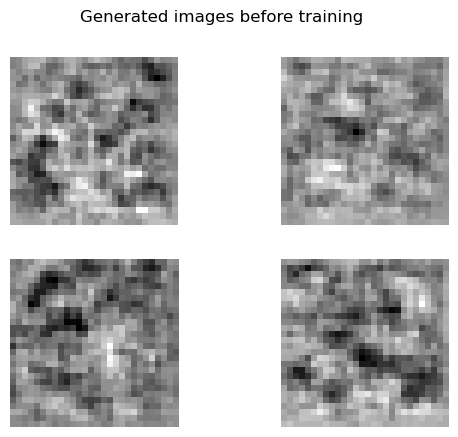

In [13]:
noise_in = tf.random.normal((4, 128), seed=32)

gen_ = generator(noise_in)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(gen_[i], cmap='gray')
    plt.axis('off')
#     plt.title(i+1)
plt.suptitle("Generated images before training")
plt.show()

# Defining the GAN class

In [14]:
from tqdm import tqdm
import numpy as np

In [15]:
# class MyGan(Model):
#     def __init__(self, generator_nn, discriminator_nn):
#         super().__init__()
#         self.generator = generator_nn
#         self.discriminator = discriminator_nn
        
#     def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
#         # Compile the parent class
#         super().compile(*args, **kwargs)
        
#         # Create attributes for losses and optimizers
#         self.g_opt = g_opt
#         self.d_opt = d_opt
#         self.g_loss = g_loss
#         self.d_loss = d_loss 
        
#     def train_step(self, batch):
#         real_data = batch
#         noise_ = tf.random.normal((512,128,1)) # noise to generate image
#         with tf.GradientTape() as d_tape:
#             gen_data = self.generator(noise_, training=False)
#             real_y = self.discriminator(real_data, training=True)
#             fake_y = self.discriminator(gen_data, training=True)
            
# #             gen_loss = self.g_loss(tf.ones_like(fake_y), fake_y)
#             dis_loss = self.d_loss(real_y, fake_y)
#         d_gradients = d_tape.gradient(dis_loss, self.discriminator.trainable_variables) # Compute gradients
#         self.d_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables)) #Apply gradients
        
#         with tf.GradientTape() as g_tape:
#             gen_data = self.generator(noise_, training=True)
#             real_y = self.discriminator(real_data, training=False)
#             fake_y = self.discriminator(gen_data, training=False)
            
#             gen_loss = self.g_loss(tf.zeros_like(fake_y), fake_y)
# #             dis_loss = self.d_loss(real_y, fake_y)
#         g_gradients = g_tape.gradient(gen_loss, self.generator.trainable_variables) # Compute gradients
#         self.g_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables)) #Apply gradients
#         return {"d_loss": dis_loss, "g_loss":gen_loss}
#         # make data to train the discriminator
# #         real_data = batch
# #         noise_ = tf.random.normal((512,128,1)) # noise to generate image
# #         gen_data = self.generator(noise_, training=False)
# # #         all_data = tf.concat([real_data, gen_data], axis=0) 
# # #         y = tf.concat([tf.zeros(real_data.shape[0]), tf.ones(gen_data.shape[0])], axis=0) # make true labels
        
# #         # Train Discriminator; Track gradients
# #         with tf.GradientTape() as d_tape:
# #             y_hat_0 = self.discriminator(real_data, training=True) # Make prediction
# #             y_hat_1 = self.discriminator(gen_data, training=True) # Make prediction
# #             y_hat = tf.concat([y_hat_0, y_hat_1], axis=0) # All predictions
# #             y = tf.concat([tf.zeros_like(y_hat_0), tf.ones_like(y_hat_1)], axis=0) # True labels; [real, fake]
# #             all_d_loss = self.d_loss(y, y_hat) # Compute loss
# #         d_gradients = d_tape.gradient(all_d_loss, self.discriminator.trainable_variables) # Compute gradients
# #         self.d_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables)) #Apply gradients
            
# #         # Train Generator; Track gradients
# #         with tf.GradientTape() as g_tape:
# # #             noise_ = tf.random.normal(batch[0].shape)
# #             gen_images = self.generator(noise_, training=True) # generate images
# #             pred = self.discriminator(gen_images, training=False) # pass through discriminator
# #             all_g_loss = self.g_loss(tf.zeros_like(pred), pred) # discriminator needs to be fooled
# # #             all_g_loss = self.g_loss(tf.ones_like(pred), pred) # experimenting
# #         g_gradients = g_tape.gradient(all_g_loss, self.generator.trainable_variables) # Compute gradients
# #         self.g_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables)) # Apply gradients
        
# #         return {"d_loss": all_d_loss, "g_loss":all_g_loss}
# # #     @tf.function
#     def train_gan(self, dataset, epochs):
#         for epoch in range(epochs):
#             d_running_loss = []
#             g_running_loss = []
#             for batch in tqdm(dataset):
#                 losses = self.train_step(batch)
#                 d_running_loss.append(losses["d_loss"])
#                 g_running_loss.append(losses["g_loss"])  
#             print(f"Epoch: {epoch+1}, d_loss: {sum(d_running_loss)/len(d_running_loss): .4f}, g_loss: {sum(g_running_loss)/len(g_running_loss): .4f}")

In [16]:
class MyGan(Model):
    def __init__(self, generator_nn, discriminator_nn):
        super().__init__()
        self.generator = generator_nn
        self.discriminator = discriminator_nn
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile the parent class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 
        
    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [17]:
generator_optimizer = Adam(learning_rate=0.0001)
discriminator_optimizer = Adam(learning_rate=0.00001)
generator_loss = BinaryCrossentropy() # can also use BinaryCrossentropy
discriminator_loss = BinaryCrossentropy() # can also use BinaryCrossentropy

In [18]:
generator = make_generator()
discriminator = make_discriminator()

mnist_gan = MyGan(generator, discriminator)

In [19]:
mnist_gan.generator.summary()
print()
print()
mnist_gan.discriminator.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [20]:
mnist_gan.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [22]:
hist = mnist_gan.fit(ds, epochs=2000)
# mnist_gan.train_gan(train_dataset, epochs=20)

Epoch 1/2000
 12/469 [..............................] - ETA: 1:10 - d_loss: 7.7125 - g_loss: 0.0000e+00

KeyboardInterrupt: 

- Shallow networks don't work at all in this GAN setup
- A Deep and well thought out network works well it seems. Need to investigate a little bit more

# Testing generator for improvement

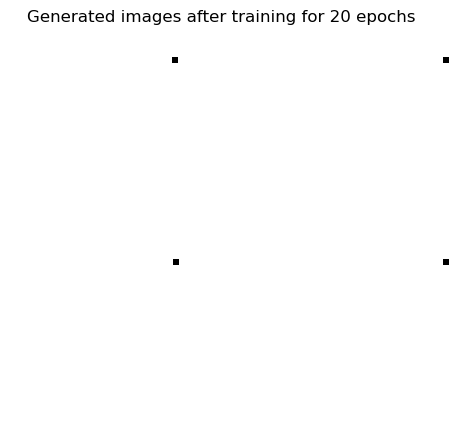

In [26]:
noise_in = tf.random.normal((4, 128, 1))

gen_ = mnist_gan.generator(noise_in)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(gen_[i], cmap='gray')
    plt.axis('off')
#     plt.title(i+1)
plt.suptitle("Generated images after training for 20 epochs")
plt.show()

# Trying something else

In [ ]:
# generator = make_generator()
# generator.summary()
# print()
# print()
# discriminator = make_discriminator()
# discriminator.summary()

In [ ]:
# noise_ = tf.random.normal((60_000, 128))
# gen_img = generator(noise_)
# gen_img.shape

In [ ]:
# dis_train = tf.concat([x_train, gen_img], axis=0)
# dis_train.shape

In [ ]:
# labels = tf.concat([tf.zeros((60_000,)), tf.ones((60_000,))], axis=0)
# labels.shape

In [ ]:
# optimizer = Adam(learning_rate=0.001)
# loss = BinaryCrossentropy()
# discriminator.compile(loss=loss, optimizer=optimizer)
# hist = discriminator.fit(dis_train, labels, batch_size=1024, epochs=5, 
#                          validation_split=0.0)

In [ ]:
# discriminator.evaluate(dis_train, labels)